In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np

import pydrake
from pydrake.all import (
    AutoDiffXd, Expression, Variable,
    MathematicalProgram, SolverType, SolutionResult,
    DirectCollocationConstraint, AddDirectCollocationConstraint,
    PiecewisePolynomial,
)

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

from traj.dircol import (
    make_real_dircol_mp,
)

from nn_system.NNSystemHelper import (
    FC, MLPSMALL, MLP,
    make_NN_constraint,
)

In [3]:
##############################
#       SETTINGS
##############################
# kNetConstructor = FC

kNetConstructor = MLPSMALL
# kNetConstructor = MLP
kNumTimesteps = 21
prog, tree = make_real_dircol_mp(expmt="acrobot", seed=1776)

# Make vars for mathematical program to know about neural network
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 4
print("total params: ", sum((num_inputs, num_states, num_params)))
T = prog.NewContinuousVariables(num_params, 'T')

# Apply this NN constraint to all timesteps!
for t in range(kNumTimesteps):
    # Only one output value, so let's have lb and ub of just size one!
    constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)
    lb         = -np.array([.001])
    ub         = np.array([.001])
    var_list   = np.hstack((prog.input(0), prog.state(0), T))
    prog.AddConstraint(constraint, lb, ub, var_list)
    pass


total params:  134


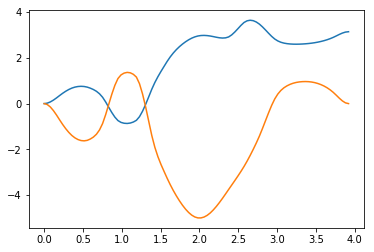

In [4]:
############################################################
# Run this cell to run the code!
############################################################

prog.SetSolverOption(SolverType.kSnopt, 'Print file', "/tmp/snopt.out")
ret = prog.Solve()

x_trajectory = prog.ReconstructStateTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
x_knots = np.hstack([x_trajectory.value(t) for t in breaks])

plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])

## Test make_NN_constraint

In [4]:
# kNetConstructor = FC
kNetConstructor = MLPSMALL
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 4
total_params = sum((num_inputs, num_states, num_params))
print("total params: ", total_params)

constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)

total params:  134


In [5]:
import copy
np.random.seed(1776)
# Make total_param # of AutoDiffXd's, with (seeded) random values.
# Set derivatives array to length total_param with only index i set for ith AutoDiff.
# values = np.random.randn(total_params)
values = np.ones(total_params)
def one_hot(i, n_params):
    ret = np.zeros(n_params)
    ret[i] = 1
    return ret

uxT = np.array([AutoDiffXd(values[i], one_hot(i, total_params)) for i in range(total_params)])
out = copy.deepcopy(constraint(uxT)[0])
out_value = out.value()
out_derivatives = out.derivatives()

# f     : function(np.array of AutoDiffXd's) -> array of size one of AutoDiffXd
# x     : np.array of AutoDiffXd at which to calculate finite_difference
# idx   : Index of AutoDiffXd in x to perturb
# delta : magnitude of perturbation of AutoDiffXd at index idx of x
def finite_difference(f, x, idx, delta):
    x_hi = copy.deepcopy(x)
    x_hi[idx] += delta
    x_lo = copy.deepcopy(x)
    x_lo[idx] -= delta
#     print(x_hi[idx], x_lo[idx])
#     print( [x.value() for x in x_hi], [x.value() for x in x_lo] )
    return ( f(x_hi)[0].value() - f(x_lo)[0].value() ) / (2*delta)

for idx in range(total_params):
    # TODO: figure out how to handle gradients of the tanh and batchnorm layers!
#     if out_derivatives[idx] == 0.:
#         continue
    
    # Do finite difference calculation and compare against gradient
    grad = finite_difference(constraint, uxT, idx, 0.1)
    ref_grad = out_derivatives[idx]
    print(idx, grad, ref_grad)

0 1.0 1.0
1 -0.0029247340192 -0.002905331695101765
2 -0.0029247340192 -0.002905331695101765
3 -0.0029247340192 -0.002905331695101765
4 -0.0029247340192 -0.002905331695101765
5 -0.000182795876196 -0.0001815832309438603
6 -0.000182795876196 -0.0001815832309438603
7 -0.000182795876196 -0.0001815832309438603
8 -0.000182795876196 -0.0001815832309438603
9 -0.000182795876196 -0.0001815832309438603
10 -0.000182795876196 -0.0001815832309438603
11 -0.000182795876196 -0.0001815832309438603
12 -0.000182795876196 -0.0001815832309438603
13 -0.000182795876196 -0.0001815832309438603
14 -0.000182795876196 -0.0001815832309438603
15 -0.000182795876196 -0.0001815832309438603
16 -0.000182795876196 -0.0001815832309438603
17 -0.000182795876196 -0.0001815832309438603
18 -0.000182795876196 -0.0001815832309438603
19 -0.000182795876196 -0.0001815832309438603
20 -0.000182795876196 -0.0001815832309438603
21 -0.000182795876196 -0.0001815832309438603
22 -0.000182795876196 -0.0001815832309438603
23 -0.000182795876196

In [11]:
x = AutoDiffXd(1., [0.1, 0.2])
x += 1
x

<AutoDiffXd 2.0 nderiv=2>

In [16]:
print(MLPSMALL())
print(list(MLPSMALL().parameters()))

MLPSMALL(
  (l1): Linear(in_features=4, out_features=16, bias=True)
  (ln1): LayerNorm(torch.Size([16]), eps=1e-05, elementwise_affine=True)
  (l3): Linear(in_features=16, out_features=1, bias=True)
)
[Parameter containing:
tensor([[ 0.0757, -0.0142,  0.0848, -0.0814],
        [-0.0377,  0.0661, -0.4897,  0.2619],
        [ 0.2305,  0.0537, -0.0722, -0.3796],
        [ 0.1554, -0.4840,  0.4360,  0.4918],
        [ 0.4527, -0.0643, -0.4547,  0.4941],
        [-0.3384, -0.4071, -0.3656,  0.2040],
        [ 0.0965, -0.2455, -0.0380, -0.1362],
        [-0.1415, -0.3651, -0.2112, -0.3530],
        [ 0.2787, -0.2712,  0.3161,  0.1796],
        [-0.2665, -0.4744,  0.4302,  0.1276],
        [-0.2210,  0.4273,  0.0434,  0.1209],
        [-0.0083, -0.1344, -0.4428,  0.1167],
        [ 0.4473,  0.3560,  0.3085,  0.4727],
        [-0.4283,  0.4581,  0.0588,  0.3790],
        [-0.4768, -0.2327, -0.0123, -0.4162],
        [ 0.1000,  0.2671,  0.4879, -0.3122]], requires_grad=True), Parameter containi

In [23]:
import torch
def load_tensor(np_data, shape):
    return torch.from_numpy(np_data.reshape(shape))
def unload_tensor(tensor):
    return tensor.numpy().flatten()
                            
inp = np.arange(0, 24, 1)
tensor = load_tensor(inp, (2, 3, 2, 2))
print("nelement(): ", tensor.nelement())
out = unload_tensor(tensor)
print(out)

nelement():  24
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
